### Draw the network diagram

In [154]:
import networkx as nx
import matplotlib.pyplot as plt

In [155]:
# Create a directed graph
G = nx.DiGraph()

In [156]:
activities = {
    'A': 3,
    'B': 5,
    'C': 4,
    'D': 8,
    'E': 3,
    'F': 2
}

In [157]:
predecessors = {
    'A': ['B'],
    'B': ['C'],
    'C': [],
    'D': ['B', 'A'],
    'E': ['A', 'C'],
    'F': ['E']
}

In [158]:
# Add nodes and edges to the graph
for activity, duration in activities.items():
    G.add_node(activity, duration=duration)

for activity, preds in predecessors.items():
    for pred in preds:
        G.add_edge(pred, activity)

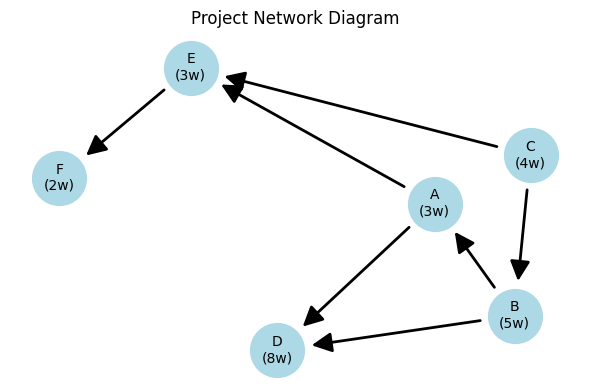

In [159]:
# draw the graph
def draw_network(G, activities):
    plt.figure(figsize=(6, 4))
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue',
                          node_size=1500,
                          node_shape='o')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, 
                          edge_color='black', 
                          arrows=True,
                          arrowsize=30,       
                          width=2,            
                          arrowstyle='-|>',   
                          min_source_margin=25, 
                          min_target_margin=25)
    
    # Add labels to nodes (activity name and duration)
    labels = {node: f"{node}\n({activities[node]}w)" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    
    plt.title("Project Network Diagram", pad=10)
    plt.axis('off')
    plt.tight_layout()
    
    return plt
  
draw_network(G, activities).show()

### Calculate the minimum overall project completion time and identify which activities are critical.

#### Minimum completion time

In [160]:
# We can sort the nodes in topological order
list(nx.topological_sort(G))

['C', 'B', 'A', 'D', 'E', 'F']

In [161]:
# what is the earliest start time for each activity?
earliest_start = {}
for node in nx.topological_sort(G):
    if not list(G.predecessors(node)):  # Start activities
        earliest_start[node] = 0
    else:
        earliest_start[node] = max(earliest_start[pred] + activities[pred] 
                                  for pred in G.predecessors(node))

earliest_start

{'C': 0, 'B': 4, 'A': 9, 'D': 12, 'E': 12, 'F': 15}

In [162]:
# from that we can calculate the earliest finish time for each activity
earliest_finish = {activity: earliest_start[activity] + duration 
                      for activity, duration in activities.items()}
earliest_finish

{'A': 12, 'B': 9, 'C': 4, 'D': 20, 'E': 15, 'F': 17}

In [163]:
# so the earliest finish time for the project is the maximum of the earliest finish times of the final activities
completion_time = max(earliest_finish.values())
completion_time

20

#### Critical activities

In [164]:
# Calculate latest finish times
latest_finish = {}
for node in reversed(list(nx.topological_sort(G))):
    if not list(G.successors(node)):  # End activities
        latest_finish[node] = completion_time
    else:
        latest_finish[node] = min(latest_finish[succ] - activities[succ] 
                                for succ in G.successors(node))
latest_finish

{'F': 20, 'E': 18, 'D': 20, 'A': 12, 'B': 9, 'C': 4}

In [165]:
# Calculate latest start times without changing the completion time
latest_start = {activity: latest_finish[activity] - duration 
                for activity, duration in activities.items()}
latest_start

{'A': 9, 'B': 4, 'C': 0, 'D': 12, 'E': 15, 'F': 18}

In [166]:
# Calculate total float times. Float time is the amount of time an activity can be delayed without delaying the project
float_times = {activity: latest_start[activity] - earliest_start[activity] 
              for activity in activities}

# Critical activities are those with zero float time
critical_activities = [activity for activity, float_time in float_times.items() 
                      if float_time == 0]

critical_activities

['A', 'B', 'C', 'D']

### What is the slack (float) time associated with each of the non-critical activities

In [167]:
non_ciritical_float_times = {activity: float_time for activity, float_time in float_times.items() if float_time > 0}
non_ciritical_float_times

{'E': 3, 'F': 3}

### Comment upon the project if, after 6 weeks, the status of the activities is as follows:
> Finished - B,C
> In progress - A (1 week to completion), D (6 weeks to completion)

_I feel like this is not as important, but here are some thoughts:_

We have the latest start times without delaying the project: 
{'A': 9, 'B': 4, 'C': 0, 'D': 12, 'E': 15, 'F': 18}

After 6 weeks, B and C are the only ones with a latest start time < 6. Since they are completed, the project is at least on time.

B is dependent on C to be completed. C was estimated to take 4 weeks, and B to take 5. Therefore, we are ahead of schedule or violated the dependency constraints.

Task A takes 3 weeks and has 1 week left. This means, it has been started in week 4. Since A is dependent on B and therefor on C, either the dependency constraint was violated or A and B took less than 4 weeks to complete.

Task D was started without waiting for task A to complete, which definitely violates the dependency constraints.